<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/1124_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.3 전이학습

큰 데이터셋을 얻기 힘들다는 한계를 보완하기 위해, 전이학습이 등장.

전이 학습: 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미. 이때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 훈련된 모델이라 함. 결과적으로 비교적 적은 수의 데이터를 가지고도 우리가 원하는 과제를 해결할 수 있음.

## 특성 추출 기법
사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듦. 학습할 때는 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 함.

이미지 분류를 위해 두 부분으로 구성됨

- 합성곱층: 합성곱층과 풀링층으로 구성
- 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서데 훈련시킴

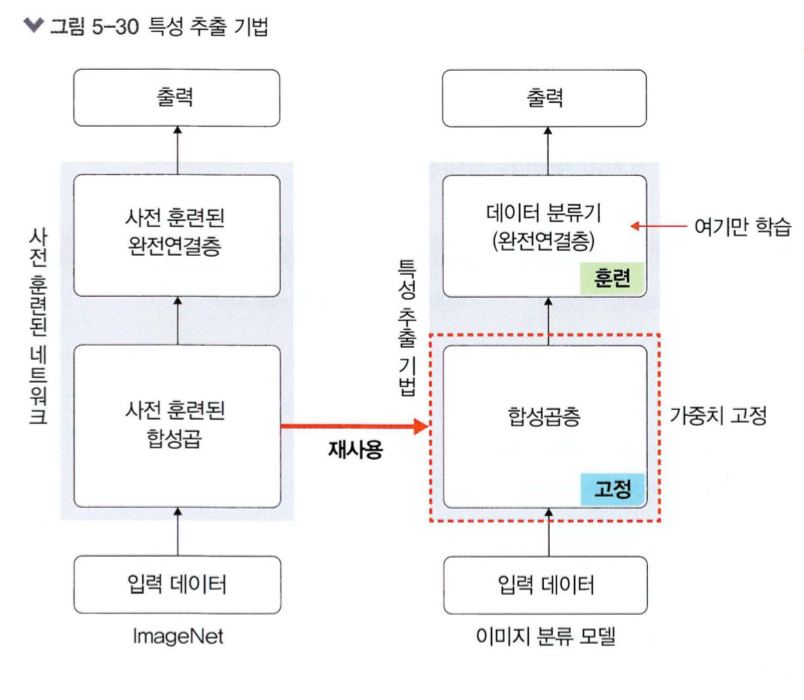

In [ ]:
# 특성 추출 예시 진행 전 라이브러리 호출

import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [21]:
# 이미지 데이터 전처리 방법 정의

data_path = "/content/drive/MyDrive/train"


transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8,
    shuffle = True
)

print(len(train_dataset))

385


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


- torchvision.transforms: 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환해 줌
1. Resize: 이미지의 크기를 조정, 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리 과정
2. RandomResizedCrop: 이미지를 랜덤한 크기 및 비율로 자름, 이미지를 랜덤한 비율로 자른 후 데이터 크기 조정
3. RandomHorizontalFlip: 이미지를 랜덤하게 수평으로 뒤집음
4. ToTensor: 이미지 데이터를 텐서로 변환

- datasets.ImageFolder: 데이터로더가 데이터를 불러올 대상과 방법을 정의함
1. 첫 번째 파라미터: 불러올 데이터가 위치한 경로
2. transform: 이미지 데이터에 대한 전처리

- 데이터로더: 데이터를 불러오는 부분
1. 첫 번째 파라미터: 데이터셋을 지정
2. batch_size: 한 번에 불러올 데이터양을 결정하는 배치 크기를 설정함
3. num_workers: 데이터를 불러올 때 하위 프로세스 몇 개 사용할지 설정, 너무 많으면 메모리 부족 발생 가능
4. shuffle: 데이터 무작위 섞고 랜덤으로 불러옴

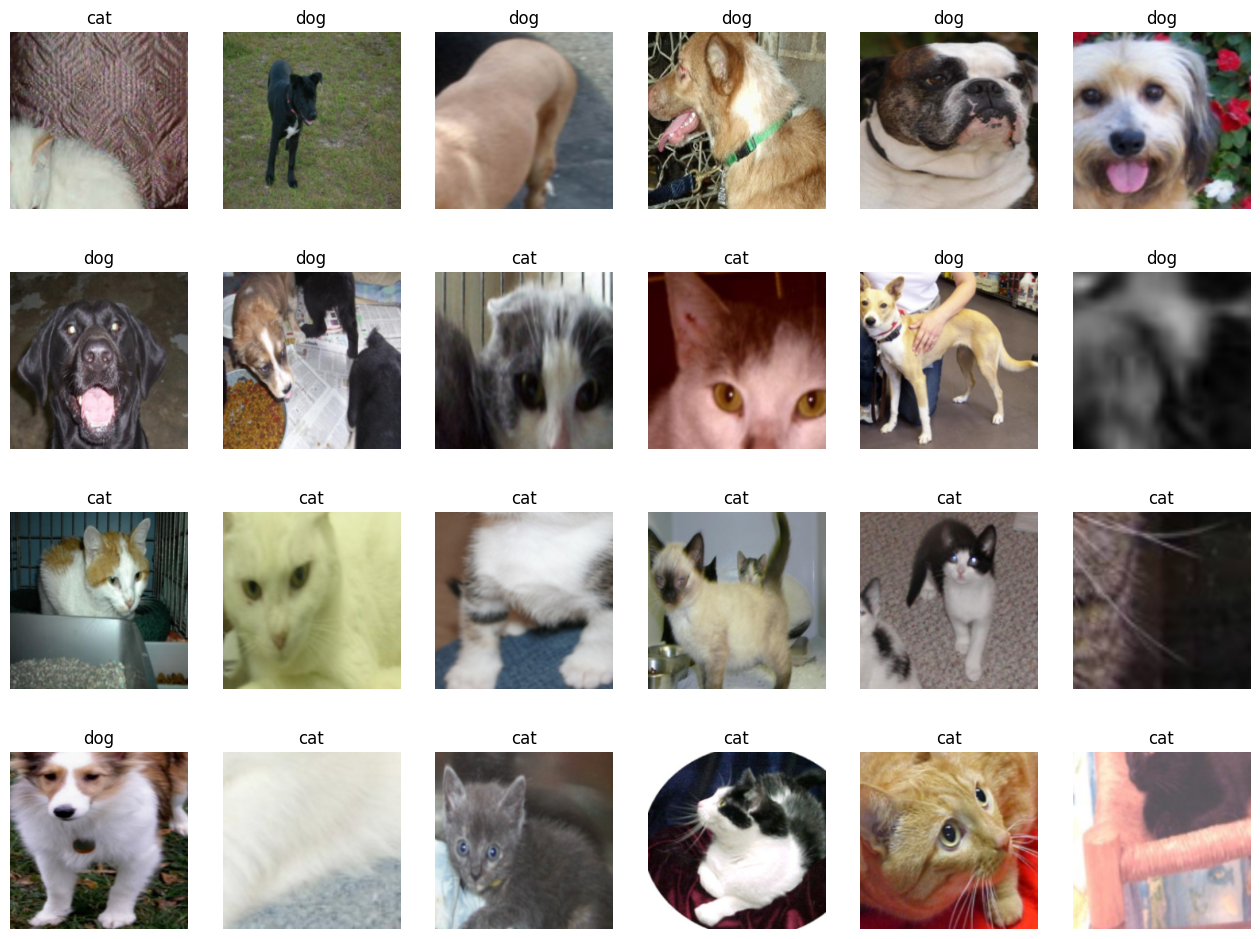

In [22]:
# 24개의 이미지에 대해 레이블 정보와 함께 출력
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace =0)

- 반복자(iterator, for 구문과 같은 효과)를 사용하려면 iter()와 next()가 필요함. iter는 전달된 데이터의 반복자를 꺼내 반환하며, next()는 그 반복자가 다음에 출력해야 할 요소를 반환함.

- np.transpose는 다음 그림과 같이 행과 열을 바꿈으로써 행렬의 차원을 바꾸어 줌. 행렬의 차원을 바꾸는 이유는 내적 연산 때문.

In [23]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


ResNet 18은 50개의 계층으로 구성된 합성곱 신경망. ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망으로, 전이 학습에 사용되도록 사전 훈련된 모델을 제공하고 있음. 그러나 충분한 메모리가 없으면 학습 속도가 느릴 수 있음.

파이토치는 import torchvision.models as models를 이용하여 무작위의 가중치로 모델을 구성할 수 있으며, pretained = True 옵션으로 사전 학습된 모델의 가중치 값을 사용 가능.

In [25]:
# ResNet18의 합성곱층을 사용하되 파라미터 학습은 하지 않도록 고정
def set_parameter_requires_grad(model, feature_extracting = True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False # 역전파 중 파라미터들에 대한 변화 계산 필요 x, 합성곱층과 풀링층 고정 의미

set_parameter_requires_grad(resnet18)

In [26]:
# 완전연결층 추가
resnet18.fc = nn.Linear(512, 2) # 클래스 두 개 의미

In [27]:
# 모델 파라미터 값 확인
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0305,  0.0032,  0.0379,  ..., -0.0396,  0.0040, -0.0319],
        [ 0.0052, -0.0227,  0.0397,  ..., -0.0025,  0.0103, -0.0316]])
fc.bias tensor([-0.0318, -0.0383])


In [29]:
# 모델 객체 생성 및 손실 함수 정의

model = models.resnet18(pretrained = True)

for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
import time
import os
import torch

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()     # 컴퓨터의 현재 시간을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):     # 에포크(13)만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:   # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()    # 기울기를 0으로 설정
            outputs = model(inputs)  # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)  # 예측 결과

            loss.backward()          # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)    # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)   # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        # 모델 저장
        torch.save(
            model.state_dict(),
            os.path.join(
                '/content/drive/MyDrive/train',
                '{0:0=2d}.pth'.format(epoch)
            )
        )
        print()

    # 에포크 반복 종료 후
    time_elapsed = time.time() - since     # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history        # 모델의 정확도와 오차를 반환

In [34]:
# 마지막으로 추가된 완전연결층이 학습하도록 설정

params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)      # 파라미터 학습 결과를 저장
        print("\t", name)

optimizer = optim.Adam(params_to_update)     # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss: 0.6091 Acc: 0.6935

Epoch 1/12
----------
Loss: 0.4162 Acc: 0.8208

Epoch 2/12
----------
Loss: 0.3257 Acc: 0.8779

Epoch 3/12
----------
Loss: 0.3037 Acc: 0.8805

Epoch 4/12
----------
Loss: 0.2413 Acc: 0.9065

Epoch 5/12
----------
Loss: 0.2202 Acc: 0.9169

Epoch 6/12
----------
Loss: 0.2195 Acc: 0.9195

Epoch 7/12
----------
Loss: 0.1850 Acc: 0.9455

Epoch 8/12
----------
Loss: 0.2523 Acc: 0.8987

Epoch 9/12
----------
Loss: 0.1774 Acc: 0.9325

Epoch 10/12
----------
Loss: 0.2453 Acc: 0.8987

Epoch 11/12
----------
Loss: 0.2247 Acc: 0.9065

Epoch 12/12
----------
Loss: 0.2068 Acc: 0.9195

Training complete in 10m 10s
Best Acc: 0.945455


모델 훈련을 위해 전달되는 파라미터는 모델, 학습데이터, 손실함수, 옵티마이저, 장치

모델 결과, 높은 정확도에서 훈련 데이터로 학습이 잘되었음을 알 수 있음.

In [36]:
# 테스트 데이터 호출 및 전처리

test_path = '/content/drive/MyDrive/test'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
])
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle = True
)

print(len(test_dataset))

98


In [38]:
# 테스트 데이터 평가 함수

def eval_model(model, dataloaders, device):

    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/test' + '*.pth')
    saved_models.sort() # 불러온 .pth 파일들을 정렬
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:  # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs)  # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0  # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                          time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history   # 계산된 정확도를 반환

In [44]:
import torch
import time
import glob

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/train/*.pth')
    saved_models.sort()  # 불러온 .pth 파일 정렬
    print('Saved models:', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.to(device)
        model.eval()

        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                          time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history


- glob
1. glob은 현재 디렉터리에서 특정 패턴과 일치하는 파일들만 추출할 때 사용한다. (예: glob('../chap05/data/catanddog/*.pth') -> ../chap05/data/catanddog/ 폴더 안에서 확장자가 .pth인 모든 파일을 가져온다는 의미)
2.	.pth 파일은 모델을 학습할 때 저장되는 모델 가중치 파일이다.

- torch.max: 텐서 배열의 최댓값이 들어 있는 인덱스 반환 함수

1. 예: y_pred = [[0.2, 8.7, 8.8, 8.4]] torch.max(y_pred.data, 1) 적용하면 가장 큰 값은 8.8, 인덱스는 2 -> 반환값: (최댓값 텐서, 인덱스 텐서)이며 여기서는 인덱스 2가 예측 결과가 된다.

- preds.eq(labels): 모델의 예측값 preds와 정답 labels가 일치하는지 검사. sum()을 붙이면 일치하는 항목의 개수를 숫자로 계산한다. 즉, “몇 개의 예측이 맞았는지”를 counting하는 역할.

In [45]:
# 성능 측정

val_acc_hist = eval_model(resnet18, test_loader,  device)

Saved models: ['/content/drive/MyDrive/train/00.pth', '/content/drive/MyDrive/train/01.pth', '/content/drive/MyDrive/train/02.pth', '/content/drive/MyDrive/train/03.pth', '/content/drive/MyDrive/train/04.pth', '/content/drive/MyDrive/train/05.pth', '/content/drive/MyDrive/train/06.pth', '/content/drive/MyDrive/train/07.pth', '/content/drive/MyDrive/train/08.pth', '/content/drive/MyDrive/train/09.pth', '/content/drive/MyDrive/train/10.pth', '/content/drive/MyDrive/train/11.pth', '/content/drive/MyDrive/train/12.pth']
Loading model /content/drive/MyDrive/train/00.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/train/01.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/train/02.pth
Acc: 0.9286

Loading model /content/drive/MyDrive/train/03.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/train/04.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/train/05.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/train/06.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/

테스트도 높은 정확도를 보임. 사전 훈련된 모델을 사용해 소요 시간이 오래 걸리는 데이터도 손쉽게 처리 가능


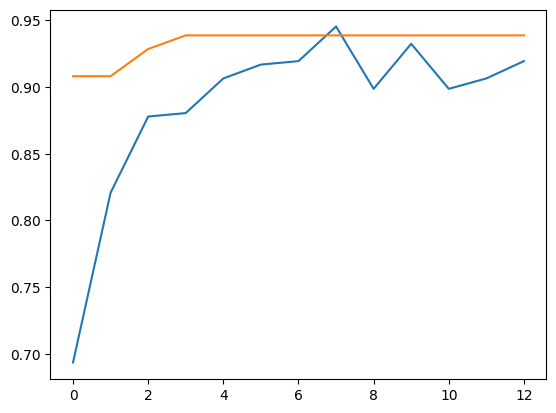

In [46]:
# 학습 결과 시각화

plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

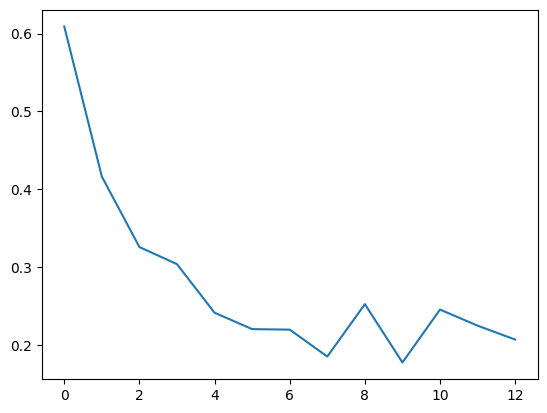

In [47]:
# 훈련 데이터의 오차에 대한 그래프 확인

plt.plot(train_loss_hist)
plt.show()

In [48]:
# 실제로 데이터를 잘 예측하는지 살펴보기에 앞서, 예측된 이미지 출력하기 위한 전처리 함수 생성

def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5,0.5,0.5)))
  image = image.clip(0,1)
  return image

tensor.clone()은 기존 텐서의 내용을 복사한 텐서를 사용하겠다는 의미, detach()는 기존 텐서에서 기울기가 전파되지 않는 텐서. 이 둘을 함께 사용하면, 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지 않겠다는 의미

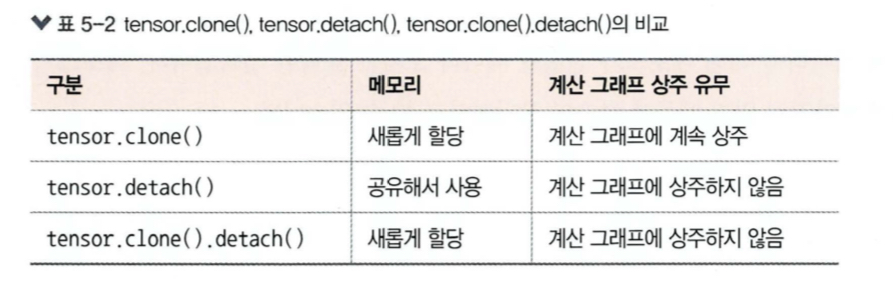

clip()은 입력값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용.

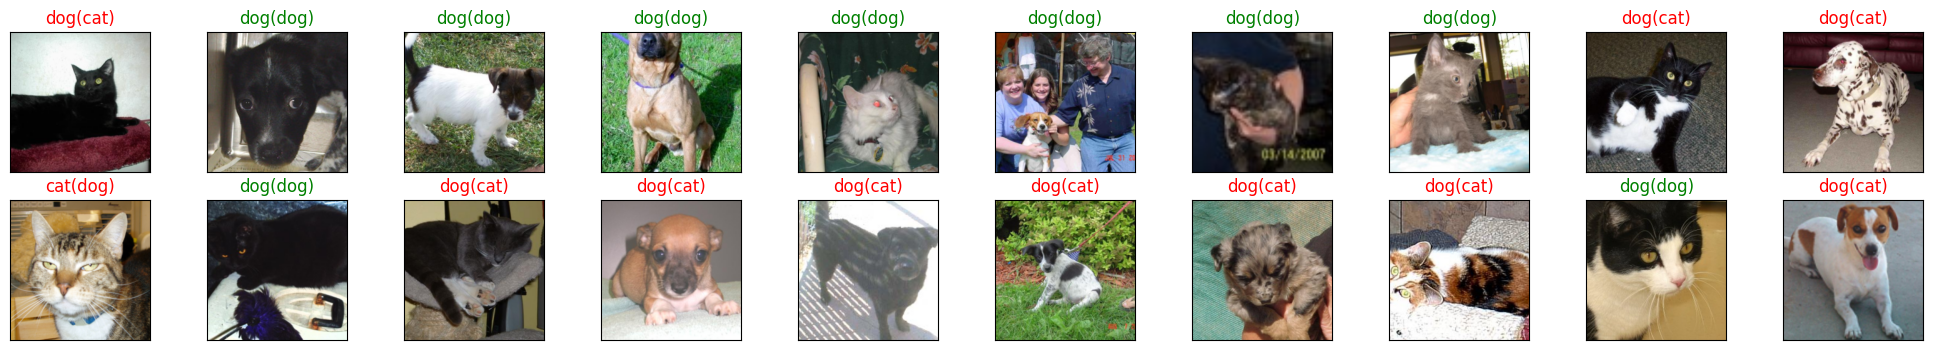

<Figure size 640x480 with 0 Axes>

In [50]:
# 개와 고양이 예측 결과 출력

classes = {0: 'cat', 1: 'dog'}

dataiter = iter(test_loader)
images, lables = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # 한 화면에 여러 개의 이미지를 담기 위해 사용, (행, 열, 인덱스, 틱 삭제 의미)
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

# 5.3.2 미세조정기법

미세조정: 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하며 훈련시키는 방식. 특성 추출은 목표 특성을 잘 추출했다는 전제하에 좋은 성능을 낼 수 있어서, 잘못 추출되었다면 미세 조정 기법으로 새로운 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트해서 특성을 다시 추출할 수 있음. 즉, 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것.

미세 조정 기법은 사전 훈련된 네트워크를 미세 조정하여 분석하려는 데이터셋에 잘 맞도록 모델의 파라미터를 조정하는 기법으로, 많은 연산량이 필요하여 GPU 환경 권장